<a href="https://colab.research.google.com/github/divSivasankaran/Misc/blob/master/CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Is Stephen Curry overpaid? Here is what Random Forest says.


## 1. Preprocessing and Exploratory Analysis

### Explore the data

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import data
data_raw = pd.read_excel('/content/drive/My Drive/Colab Notebooks/nba_basic.xlsx')
# drop irrelevant columns
data_raw = data_raw.drop(columns=['#', 'blanl', 'blank2'])
# rename some columns
data_raw = data_raw.rename(columns={'Season Start': 'season',
                                    'Player Name': 'name',
                                    'Player Salary in $': 'salary'})

**Take-home message 1**: get an overall idea of your data before analyzing it, and visualization helps.

In [0]:
# drop all rows with at least one NaN
data_raw = data_raw.dropna(axis='index')
# transform columns to proper data types
data_raw['season'] = data_raw['season'].astype('int64')
data_raw['salary'] = data_raw['salary'].astype('float64')
data_raw['Pos'] = data_raw['Pos'].astype('category')
data_raw['Tm'] = data_raw['Tm'].astype('category')
print(data_raw.shape)
data_raw.head()

(9301, 51)


,season,name,salary,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
4,1990,A.C. Green,1750000.0,PF,26.0,LAL,82.0,82.0,2709.0,14.7,0.548,0.057,0.459,11.5,18.4,15.1,4.6,1.2,1.1,10.7,17.1,4.4,3.3,7.7,0.137,0.3,0.0,0.4,1.6,385.0,806.0,0.478,13.0,46.0,0.283,372.0,760.0,0.489,0.486,278.0,370.0,0.751,262.0,450.0,712.0,90.0,66.0,50.0,116.0,207.0,1061.0
5,1991,A.C. Green,1750000.0,PF,27.0,LAL,82.0,21.0,2164.0,13.8,0.556,0.101,0.557,11.3,16.2,13.8,4.5,1.4,0.6,12.8,15.6,3.2,2.9,6.1,0.135,0.0,0.6,0.5,1.4,258.0,542.0,0.476,11.0,55.0,0.200,247.0,487.0,0.507,0.486,223.0,302.0,0.738,201.0,315.0,516.0,71.0,59.0,23.0,99.0,117.0,750.0
6,1992,A.C. Green,1750000.0,PF,28.0,LAL,82.0,53.0,2902.0,16.7,0.556,0.070,0.569,11.8,18.2,14.9,6.0,1.6,0.8,10.0,16.8,5.8,2.9,8.8,0.145,1.2,0.2,1.4,2.5,382.0,803.0,0.476,12.0,56.0,0.214,370.0,747.0,0.495,0.483,340.0,457.0,0.744,306.0,456.0,762.0,117.0,91.0,36.0,111.0,141.0,1116.0
7,1993,A.C. Green,1885000.0,PF,29.0,LAL,82.0,55.0,2819.0,16.3,0.603,0.065,0.531,11.5,17.3,14.4,5.9,1.6,0.9,11.8,15.0,6.1,2.6,8.6,0.147,1.6,0.5,2.1,2.9,379.0,706.0,0.537,16.0,46.0,0.348,363.0,660.0,0.550,0.548,277.0,375.0,0.739,287.0,424.0,711.0,116.0,88.0,39.0,116.0,149.0,1051.0
8,1994,A.C. Green,6472600.0,PF,30.0,PHO,82.0,55.0,2825.0,17.0,0.555,0.038,0.391,11.1,18.8,15.0,6.9,1.2,0.8,8.4,17.6,6.7,2.6,9.3,0.157,1.5,-0.3,1.2,2.3,465.0,926.0,0.502,8.0,35.0,0.229,457.0,891.0,0.513,0.506,266.0,362.0,0.735,275.0,478.0,753.0,137.0,70.0,38.0,100.0,142.0,1204.0


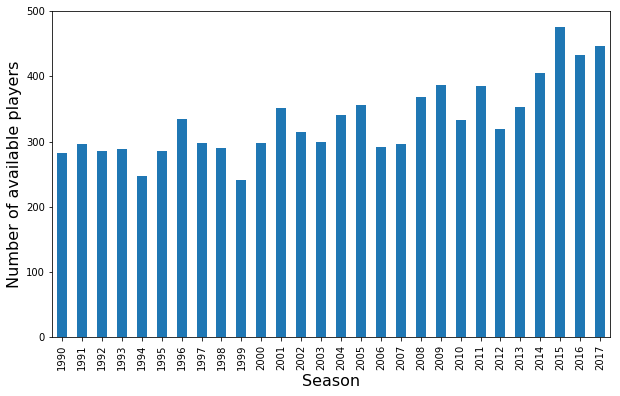

In [0]:
# group data by season
data_season = data_raw.groupby(['season'])
# visualizethe number available player by season
ax_count = data_season['name'].count().plot(kind='bar', figsize=(10,6))
ax_count.set_xlabel('Season', fontsize = 16)
ax_count.set_ylabel('Number of available players', fontsize = 16)
plt.show()

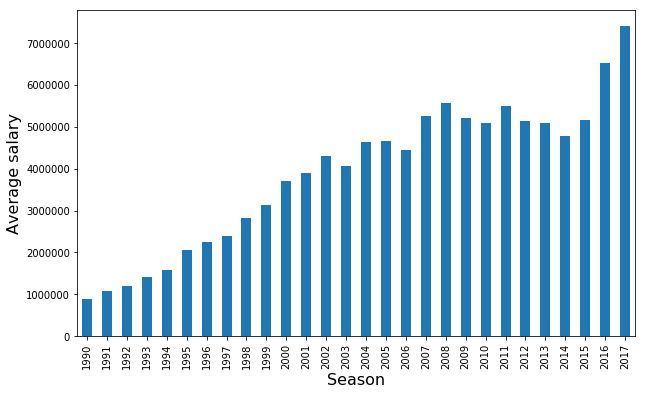

In [0]:
# visualize average salary by season
ax_salary = data_season['salary'].mean().plot(kind='bar', figsize=(10,6))
ax_salary.set_xlabel('Season', fontsize = 16)
ax_salary.set_ylabel('Average salary', fontsize = 16)
plt.show()

### Pre-processing

**Take-home message 2**: Pre-processing is as important, if not more, as training model.

Apparently, the average salary gradually increases over time as a result of inflation (and other factors). This has to be addressed before any reliable prediction model for salary can be built. We normalize the salary by dividing it by **team salary CAP**, which is set before the season starts, i.e.,
$$\mbox{cap_percent} = \frac{\mbox{salary}}{\mbox{team salary cap}} \times 100$$

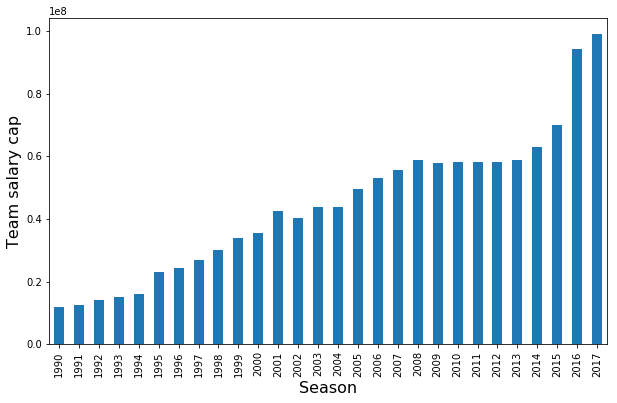

In [0]:
# import team cap data
team_cap = pd.read_csv('/content/drive/My Drive/Colab Notebooks/team_cap.csv')
ax_team_cap = team_cap.plot(x='season', y='team_cap', kind='bar', figsize=(10,6))
ax_team_cap.set_xlabel('Season', fontsize = 16)
ax_team_cap.set_ylabel('Team salary cap', fontsize = 16)
ax_team_cap.get_legend().remove()
plt.show()

In [0]:
# normalize salary
data_norm = pd.merge(data_raw, team_cap, on='season')
data_norm['salary_norm'] = data_norm['salary']/data_norm['team_cap']
data_norm[['season', 'name', 'salary', 'team_cap','salary_norm']]. \
sort_values(by=['salary_norm'], ascending=False).head(n=10)

,season,name,salary,team_cap,salary_norm
1924,1996,Michael Jordan*,30140000.0,24363000,1.237122
7627,1997,Michael Jordan*,33140000.0,26900000,1.231970
1603,1995,Patrick Ewing*,18724000.0,23000000,0.814087
7637,1997,Patrick Ewing*,20500000.0,26900000,0.762082
8871,2003,Kevin Garnett,28000000.0,43840000,0.638686
3369,2002,Kevin Garnett,25200000.0,40271000,0.625760
2245,1998,Patrick Ewing*,18500000.0,30000000,0.616667
1845,1996,Horace Grant,14857000.0,24363000,0.609818
438,1991,Larry Bird*,7070000.0,12500000,0.565600
2724,2000,Kevin Garnett,19610000.0,35500000,0.552394


In [0]:
# generate dummy variables for categorical features
cat_features = ['Pos', 'Tm']
non_features = ['season', 'name', 'salary', 'team_cap', 'salary_norm']
num_features = [x for x in data_norm.columns.tolist() if ((x not in cat_features) & (x not in non_features))]
data_norm = pd.concat([data_norm, pd.get_dummies(data_norm[cat_feature])], axis=1)
data_norm = data_norm.drop(columns=cat_feature)
data_norm.head()

,season,name,salary,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,...,Pos_SG-SF,Tm_ATL,Tm_BOS,Tm_BRK,Tm_CHA,Tm_CHH,Tm_CHI,Tm_CHO,Tm_CLE,Tm_DAL,Tm_DEN,Tm_DET,Tm_GSW,Tm_HOU,Tm_IND,Tm_LAC,Tm_LAL,Tm_MEM,Tm_MIA,Tm_MIL,Tm_MIN,Tm_NJN,Tm_NOH,Tm_NOK,Tm_NOP,Tm_NYK,Tm_OKC,Tm_ORL,Tm_PHI,Tm_PHO,Tm_POR,Tm_SAC,Tm_SAS,Tm_SEA,Tm_TOR,Tm_TOT,Tm_UTA,Tm_VAN,Tm_WAS,Tm_WSB
0,1990,A.C. Green,1750000.0,26.0,82.0,82.0,2709.0,14.7,0.548,0.057,0.459,11.5,18.4,15.1,4.6,1.2,1.1,10.7,17.1,4.4,3.3,7.7,0.137,0.3,0.0,0.4,1.6,385.0,806.0,0.478,13.0,46.0,0.283,372.0,760.0,0.489,0.486,278.0,370.0,0.751,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1990,Adrian Dantley*,400000.0,33.0,45.0,45.0,1300.0,15.4,0.556,0.004,0.525,6.9,8.1,7.5,9.6,0.8,0.3,11.2,22.6,2.2,0.8,3.1,0.113,0.5,-1.7,-1.2,0.3,231.0,484.0,0.477,0.0,2.0,0.000,231.0,482.0,0.479,0.477,200.0,254.0,0.787,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1990,Alex English*,1500000.0,36.0,80.0,80.0,2211.0,17.9,0.522,0.004,0.142,5.3,8.4,6.8,15.6,1.1,0.6,6.3,26.0,3.3,1.7,5.1,0.110,1.5,-1.7,-0.2,1.0,635.0,1293.0,0.491,2.0,5.0,0.400,633.0,1288.0,0.491,0.492,161.0,183.0,0.880,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1990,Alexander Volkov,650000.0,25.0,72.0,4.0,937.0,11.9,0.530,0.120,0.423,6.2,8.5,7.3,12.3,1.9,1.4,13.4,17.4,1.0,0.4,1.4,0.074,0.2,-0.8,-0.7,0.3,137.0,284.0,0.482,13.0,34.0,0.382,124.0,250.0,0.496,0.505,70.0,120.0,0.583,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1990,Alton Lister,1700000.0,31.0,3.0,0.0,40.0,10.9,0.542,0.125,0.875,14.0,7.6,10.7,6.4,1.1,0.0,0.0,11.0,0.1,0.0,0.1,0.125,1.6,-2.5,-0.9,0.0,4.0,8.0,0.500,0.0,1.0,0.000,4.0,7.0,0.571,0.500,4.0,7.0,0.571,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Train/test split

**Take-home message 3**: Always leave out some data for evaluation, and NEVER leak that to the learning process.

Let's only consider **seasons after 2010**, and use data from Season 2011-2016 for training. The trained model is applied to predict player salary in Season 2017.

In [0]:
# train/test data split
train = data_norm[(data_norm.season > 2010) & (data_norm.season < 2017)]
test = data_norm[data_norm.season == 2017]
print(train.shape)
print(test.shape)

train_x = train.drop(columns=non_features)
train_y = train.salary_norm

test_x = test.drop(columns=non_features)
test_y = test.salary_norm

(2371, 105)
(447, 105)


### Correlation analysis

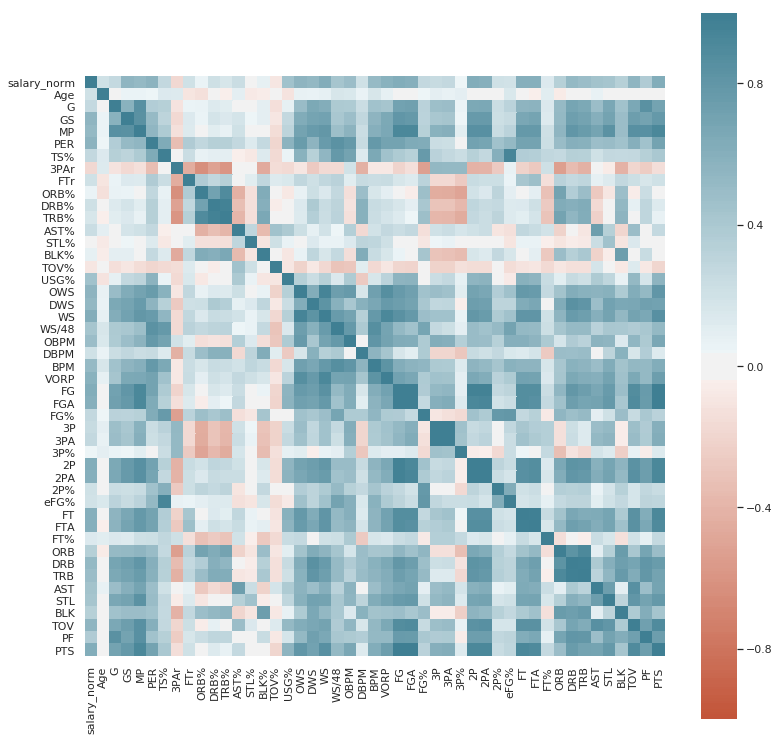

In [0]:
# visualize the correlation between salary and features
import seaborn as sns
sns.set(rc={'figure.figsize':(13,13)})

# drop irrelevant features
train_corr = pd.concat([train_y, train_x[num_features]], axis=1).corr()
# draw heatmap
ax_hm = sns.heatmap(
    train_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
plt.show()

## Decision Tree and Random Forest


### Decision Tree
Decision trees are predictive models that use  a set of **binary rules** to calculate a target value. 

(**non-parametric, supervised classification and regression**)

Some **key concepts** for decision trees include:
- ROOT node
- Splitting
- Decision node
- Leaf/Terminal Node
- Branch/Sub-tree
- Tree depth


In [0]:
from sklearn.tree import DecisionTreeRegressor
# create a decision tree regressor
dtr = DecisionTreeRegressor(max_depth=3, random_state=0)
# fit with training data
dtr.fit(train_x, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [0]:
from sklearn.tree import export_graphviz
# Export the tree as dot file
# the dot file is converted to png locally
export_graphviz(dtr, out_file='tree.dot', 
                feature_names = train_x.columns.tolist(),
                class_names = 'salary_norm',
                rounded = True, proportion = False, 
                precision = 5, filled = True)

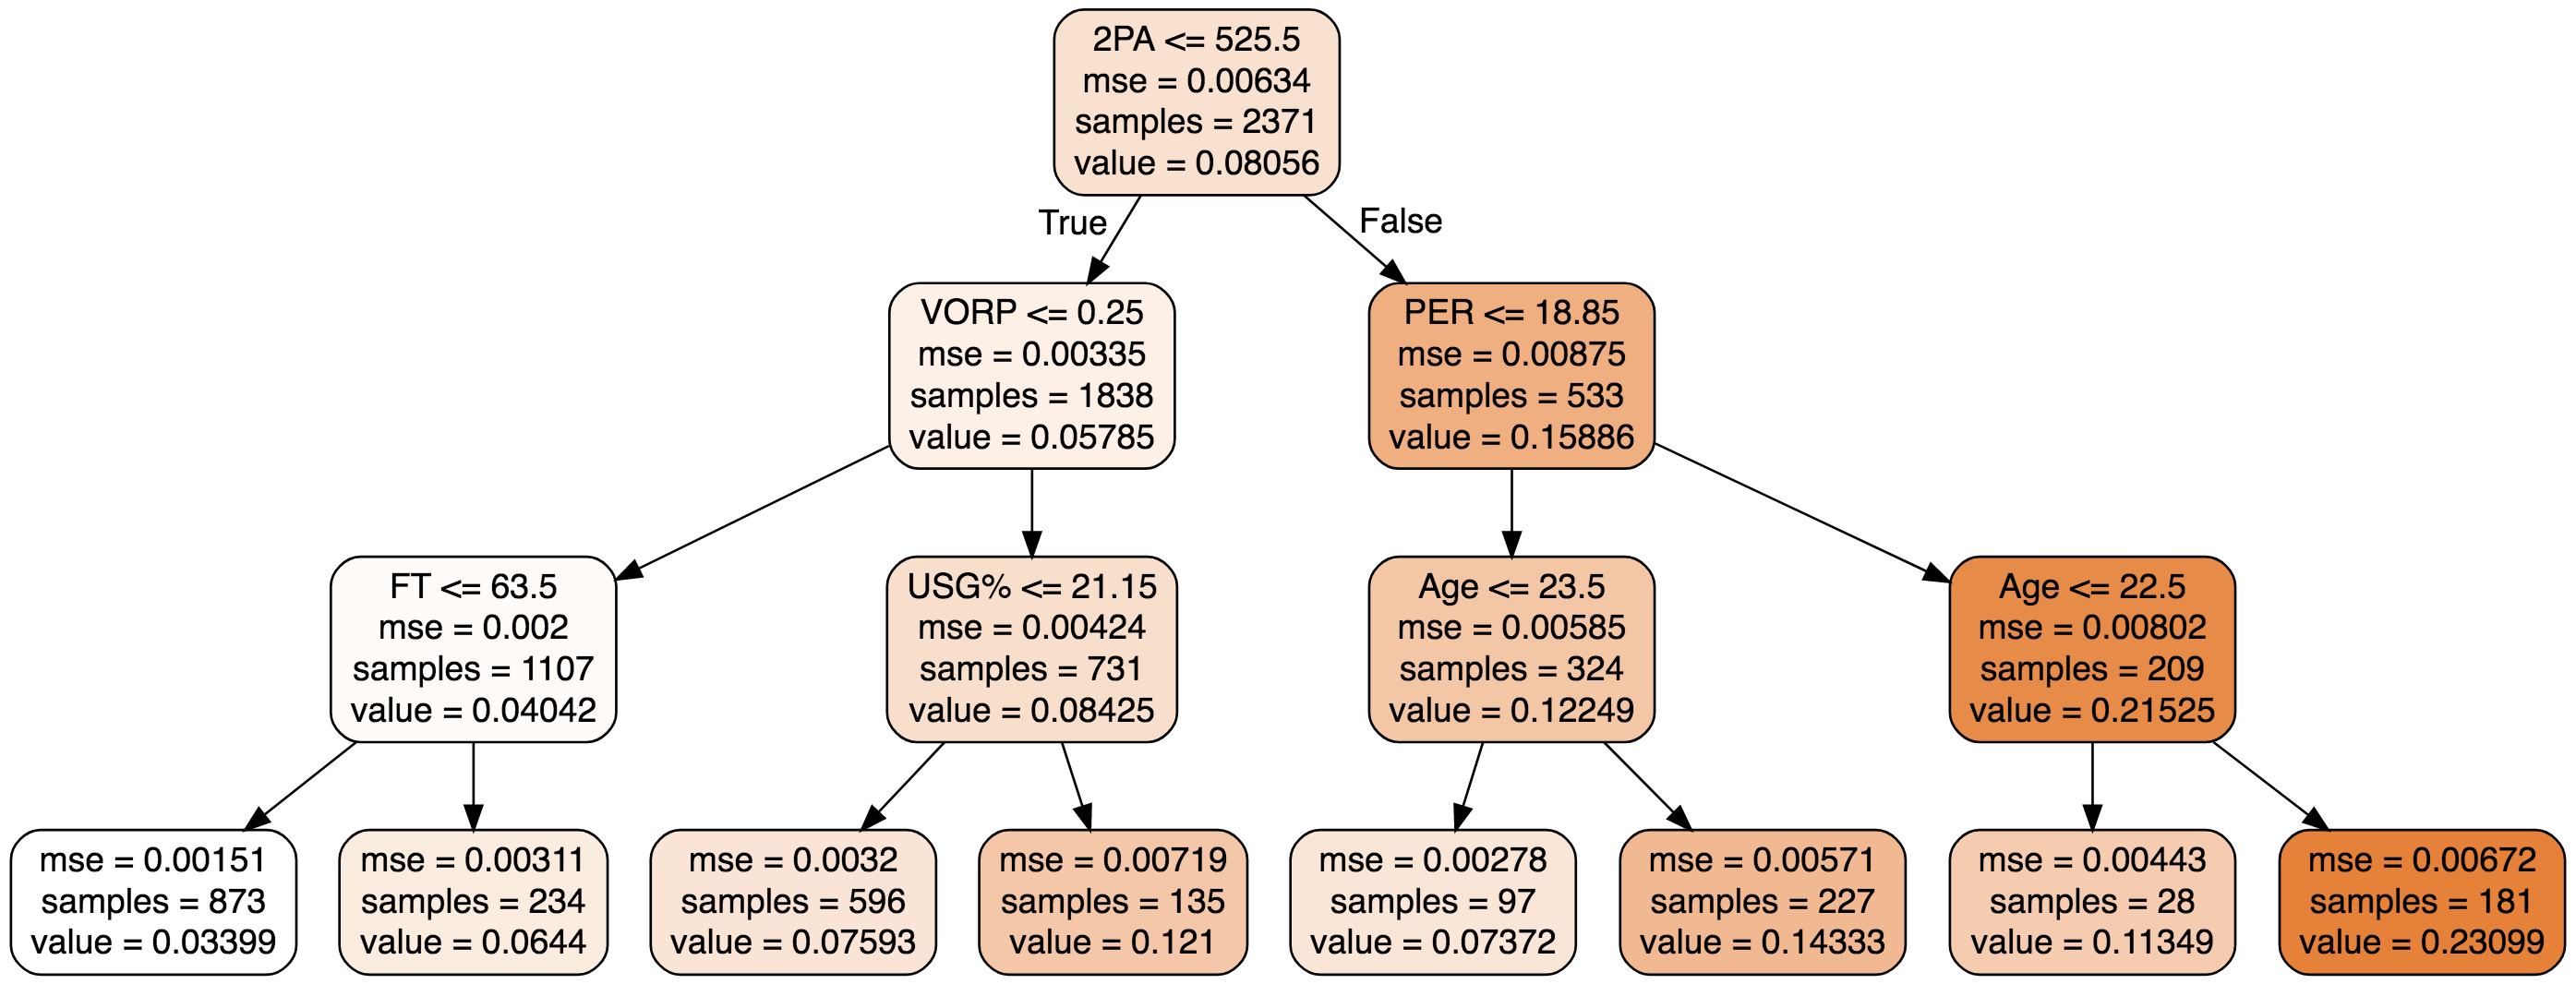

In [0]:
# Display the tree in notebook
from IPython.display import Image
Image("/content/drive/My Drive/Colab Notebooks/tree.png", width=1250, height=500)

**QUESTIONS**:

- Which feature to use?

  *Best regarding the reduction of selected criterion (**loss function!**).*
  
- What threshold to use?

   *Best regarding the reduction of selected criterion (**loss function!**).*
  
- When to stop splitting?

  *Stopping criterion.*
  
See [here](https://scikit-learn.org/stable/modules/tree.html) for details.
  
Some examples of criterion:

**Mean Squared Error (MSE)**:
$$\mbox{MSE}(y, \hat{y})=\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$
**Mean Absolute Error (MAE)**:
$$\mbox{MAE}(y, \hat{y})=\frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# make predictions
dtr_pred = dtr.predict(test_x)
dtr_mse = mean_squared_error(test_y, dtr_pred)
dtr_mae = mean_absolute_error(test_y, dtr_pred)
# evaluate performance with MSE and MAE
print('MSE is {}'.format(dtr_mse))
print('MAE is {}'.format(dtr_mae))

MSE is 0.0027736233138636614
MAE is 0.039833278913469196


**Feature importance:**
Computed as the **(normalized) total** reduction of the criterion brought by that feature. It is also known as the *Gini importance*.

**Advantages**:
 - Simple to interpret
 - Require little data pre-processing
 - Flexible
 
**Limitations**:
 - Local optimality
 - Cannot extrapolate
 - Prone to overfitting
 - Very non-robust
 
***TRY OUT YOURSELF***: 
- take a random subset of the training data
- grow a tree again with the subset
- check how the tree and predictions change

### Random Forest

$$Random \; Forest = Randomly \; grow \; multiple \; trees \; (forest)$$

It is an **ensemble** method that improves the performance of a single decision tree by growing many trees then aggregating them.

**Take-home message 4**: randomness (diversity) is a good thing!

Two sources of randomness in Random Forest:
- Bootstrap the training sample (**Bagging**)
>Bootstrap is a technique that takes simple random samples **WITH** replacement from a set.
- Use random subset of features for splitting

Simple averaging is often used for aggregation.

In [0]:
from sklearn.ensemble import RandomForestRegressor
# create a random forest regressor
rfr = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=200)
# fit with training data
rfr.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
# make predictions
rfr_pred = rfr.predict(test_x)
rfr_mse = mean_squared_error(test_y, rfr_pred)
rfr_mae = mean_absolute_error(test_y, rfr_pred)
# evaluate performance with MSE and MAE
print('MSE is {}'.format(rfr_mse))
print('which is {:.2f}% of that of DT'.format(rfr_mse/dtr_mse*100))
print('MAE is {}'.format(rfr_mae))
print('which is {:.2f}% of that of DT'.format(rfr_mae/dtr_mae*100))

MSE is 0.002266714260402485
which is 81.72% of that of DT
MAE is 0.03730659295595466
which is 93.66% of that of DT


**Hyperparameter tuning using K-fold cross-validation**

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# tune hyperparameters by randomized search cross-validation
# specify hyperparameter values to search over
rfr_param_dist = {'max_depth': [3, 6, 9, 12],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'n_estimators': [100, 200, 300]}
# set up parameters to perform RSCV
rscv = RandomizedSearchCV(RandomForestRegressor(), rfr_param_dist,
                          n_iter=20, scoring='neg_mean_squared_error',
                          random_state=0, verbose=1, n_jobs=8)
# fit with data
rscv.fit(train_x, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:  2.1min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st

In [0]:
# hyperparamter of the optimal estimator
rscv.best_params_

{'max_depth': 9, 'max_features': 'auto', 'n_estimators': 300}

In [0]:
# make predictions
rfr_tuned_pred = rscv.best_estimator_.predict(test_x)
# evaluate performance with MSE and MAE
rfr_tuned_mse = mean_squared_error(test_y, rfr_tuned_pred)
rfr_tuned_mae = mean_absolute_error(test_y, rfr_tuned_pred)
print('MSE is {}'.format(rfr_tuned_mse))
print('which is {:.2f}% of that of DT'.format(rfr_tuned_mse/dtr_mse*100))
print('MAE is {}'.format(rfr_tuned_mae))
print('which is {:.2f}% of that of DT'.format(rfr_tuned_mae/dtr_mae*100))

MSE is 0.0019982363835436175
which is 72.04% of that of DT
MAE is 0.03298799702543342
which is 82.82% of that of DT


**Post-training Interpretation**

In [0]:
# averaged feature importance
importances = rscv.best_estimator_.feature_importances_
importance_df = pd.DataFrame(data=importances,
                             index=train_x.columns.tolist(),
                             columns=['score'])
importance_df.sort_values(by='score', ascending=False).head(n=20)

,score
PER,0.151162
FG,0.107684
Age,0.080437
2PA,0.071004
PTS,0.070228
GS,0.056642
G,0.048235
USG%,0.041353
VORP,0.033640
FGA,0.024512


In [0]:
# compare true salary with predicted salary
pred_out = pd.concat([pd.DataFrame(rfr_tuned_pred, columns=['salary_pred']),
                      test[['salary_norm', 'name']].reset_index(drop=True)], axis=1)
pred_out['diff'] = pred_out['salary_norm'] - pred_out['salary_pred']
# most under paid players
pred_out.sort_values('diff').head(10)

,salary_pred,salary_norm,name,diff
146,0.247658,0.063187,Isaiah Thomas,-0.184471
259,0.243536,0.070641,Lou Williams,-0.172896
101,0.168084,0.021363,Derrick Rose,-0.146720
189,0.187664,0.061561,Joel Embiid,-0.126103
258,0.183137,0.070641,Lou Williams,-0.112496
313,0.113829,0.014848,Nikola Jokic,-0.098980
169,0.118501,0.021363,JaVale McGee,-0.097138
105,0.144462,0.050458,Dirk Nowitzki,-0.094004
90,0.273700,0.182292,DeMarcus Cousins,-0.091408
218,0.120420,0.029743,Jusuf Nurkic,-0.090677


In [0]:
# most over paid players
pred_out.sort_values('diff').tail(10)

,salary_pred,salary_norm,name,diff
125,0.064972,0.172879,Evan Turner,0.107907
427,0.101068,0.211922,Victor Oladipo,0.110854
208,0.146751,0.259218,Jrue Holiday,0.112467
3,0.161982,0.279883,Al Horford,0.117900
334,0.195924,0.315554,Paul Millsap,0.119631
382,0.227496,0.350000,Stephen Curry,0.122504
151,0.108967,0.232105,J.J. Redick,0.123139
322,0.118773,0.250000,Otto Porter,0.131227
383,0.083010,0.226776,Steven Adams,0.143766
56,0.076767,0.233235,Chandler Parsons,0.156468


Wait! Why are there two Lou Williams ??

**Take-home message 5**: unexpected things could happen at any time!

In [0]:
# what happened to Lou??
data_raw[(data_raw.name=='Lou Williams') & (data_raw.season == 2017)]

,season,name,salary,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
15352,2017.0,Lou Williams,7000000,SG,30.0,TOT,81.0,1.0,1994.0,21.4,0.593,0.447,0.458,1.4,9.9,5.5,19.9,1.9,0.8,11.8,29.1,5.1,1.0,6.1,0.147,3.7,-3.0,0.8,1.4,428.0,998.0,0.429,163.0,446.0,0.365,265.0,552.0,0.480,0.511,402.0,457.0,0.880,26.0,176.0,202.0,239.0,80.0,19.0,160.0,92.0,1421.0
15353,2017.0,Lou Williams,7000000,SG,30.0,LAL,58.0,1.0,1403.0,23.9,0.609,0.432,0.469,1.1,9.5,5.1,22.3,2.3,0.6,11.9,30.6,4.3,0.6,4.9,0.169,5.4,-3.2,2.2,1.5,326.0,734.0,0.444,122.0,317.0,0.385,204.0,417.0,0.489,0.527,304.0,344.0,0.884,14.0,118.0,132.0,183.0,65.0,10.0,120.0,67.0,1078.0
15354,2017.0,Lou Williams,7000000,SG,30.0,HOU,23.0,0.0,591.0,15.4,0.547,0.489,0.428,2.2,10.7,6.5,14.3,1.2,1.2,11.3,25.3,0.8,0.4,1.2,0.096,-0.1,-2.5,-2.6,-0.1,102.0,264.0,0.386,41.0,129.0,0.318,61.0,135.0,0.452,0.464,98.0,113.0,0.867,12.0,58.0,70.0,56.0,15.0,9.0,40.0,25.0,343.0


**Advantages**:
 - ~~Simple to interpret~~
 - Require little data pre-processing
 - Flexible
 
**Limitations**:
 - Local optimality
 - Cannot extrapolate
 - ~~Prone to overfitting~~
 - ~~Very non-robust~~

**TRY OUT YOURSELF**:
- remove duplicated players in the dataset (only keep "total")
- re-train the model
- check if results significantly change